<a href="https://www.kaggle.com/code/zheedong/cat-dog-pytorch?scriptVersionId=109156604" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


In [2]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F

import torchvision
from torchvision import transforms, datasets, models
from torchvision.datasets import ImageFolder

from PIL import Image
import matplotlib.pyplot as plt

# Image directory building

In [3]:
base_dir = "../input/dogs-vs-cats"
train_zip = os.path.join(base_dir, "train.zip")
test_zip = os.path.join(base_dir, "test1.zip")

In [4]:
# Unzip datasets
import zipfile
with zipfile.ZipFile(train_zip,"r") as z:
    z.extractall()
with zipfile.ZipFile(test_zip, "r") as z:
    z.extractall()

In [5]:
train_dir = "./train"

In [6]:
# Make directorys which save data (For ImageFolder)
try:
    if not os.path.exists(f"{train_dir}/cat"):
        os.makedirs(f"{train_dir}/cat")
    if not os.path.exists(f"{train_dir}/dog"):
        os.makedirs(f"{train_dir}/dog")
except OSError:
    print("ERROR : Creating Directory")

In [7]:
import shutil

# Move data according to its name
for file_name in os.listdir(train_dir):
    try:
        cat_or_dog, _, _ = file_name.split(".")
        if cat_or_dog == "cat":
            shutil.move(f"{train_dir}/{file_name}", f"{train_dir}/cat/{file_name}")
        elif cat_or_dog == "dog":
            shutil.move(f"{train_dir}/{file_name}", f"{train_dir}/dog/{file_name}")
        else:
            print("ERROR : No label")
            break
    except:
        continue
        
print(os.listdir(train_dir))

['dog', 'cat']


# Make Custom DataLoader via ImageFolder

In [8]:
data_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

dataset = torchvision.datasets.ImageFolder(root=train_dir, transform=data_transform)
print(dataset.class_to_idx)
idx_to_class = {v:k for k,v in dataset.class_to_idx.items()}

{'cat': 0, 'dog': 1}


In [9]:
data_size = len(dataset)
# Random split dataset
train_dataset, validation_dataset = random_split(dataset, [int(0.8 * data_size), int(0.2 * data_size)])

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=1, shuffle=True)

torch.Size([1, 3, 256, 256])
This is... dog


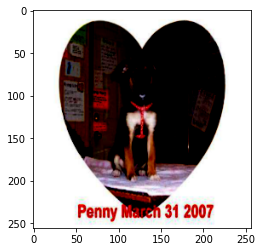

In [10]:
for value in train_dataloader:
    data, label = value
    print(data.shape)
    print(f"This is... {idx_to_class[int(label.item())]}")
    plt.imshow(torch.squeeze(data).permute(1, 2, 0))
    break

# Make Prediction Model

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


## Scratch traing

In [12]:
# Accuraccy 50% model == Equal to random choice
class VanilaMyNet(nn.Module):
    def __init__(self):
        super(VanilaMyNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=5, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(24)
        self.pool = nn.MaxPool2d(2,2)
        self.conv3 = nn.Conv2d(in_channels=24, out_channels=12, kernel_size=5, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(12)
        self.fc1 = nn.Linear(187500, 2)

    def forward(self, input):
        output = F.relu(self.bn1(self.conv2(self.conv1(input))))
        output = self.pool(output)
        output = F.relu(self.bn2(self.conv3(output)))
        output = output.view(-1, 187500)
        output = self.fc1(output)

        return output

## Transfer learning

In [13]:
resnet18_pretrained = models.resnet18(pretrained=True,progress=True)
num_ftrs = resnet18_pretrained.fc.in_features
num_classes = 2
resnet18_pretrained.fc = nn.Linear(num_ftrs, num_classes)
print(resnet18_pretrained)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Train Model

In [14]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 500 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")
            
def validation(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}\n")

In [15]:
#model = VanilaMyNet().to(device)
model = resnet18_pretrained.to(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

In [17]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n---------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    validation(validation_dataloader, model, loss_fn)
print("Done!")

Epoch 1
---------------------
loss: 0.931653 [    0/20000]
loss: 0.616861 [  500/20000]
loss: 0.659329 [ 1000/20000]
loss: 0.295014 [ 1500/20000]
loss: 0.159096 [ 2000/20000]
loss: 0.142747 [ 2500/20000]
loss: 0.080647 [ 3000/20000]
loss: 0.834107 [ 3500/20000]
loss: 2.000719 [ 4000/20000]
loss: 0.033295 [ 4500/20000]
loss: 0.025469 [ 5000/20000]
loss: 0.027530 [ 5500/20000]
loss: 0.023907 [ 6000/20000]
loss: 0.020017 [ 6500/20000]
loss: 0.012284 [ 7000/20000]
loss: 0.019752 [ 7500/20000]
loss: 0.013812 [ 8000/20000]
loss: 0.016586 [ 8500/20000]
loss: 0.018168 [ 9000/20000]
loss: 0.268448 [ 9500/20000]
loss: 0.012191 [10000/20000]
loss: 0.019307 [10500/20000]
loss: 0.011579 [11000/20000]
loss: 0.007092 [11500/20000]
loss: 0.012225 [12000/20000]
loss: 0.009024 [12500/20000]
loss: 0.009744 [13000/20000]
loss: 0.010751 [13500/20000]
loss: 0.046654 [14000/20000]
loss: 0.038333 [14500/20000]
loss: 0.009234 [15000/20000]
loss: 0.005957 [15500/20000]
loss: 0.275234 [16000/20000]
loss: 0.00424

# Let's Predict!

In [18]:
test_dir = "./test1"
# Make directorys which save data (For ImageFolder)
try:
    if not os.path.exists(f"{test_dir}/test"):
        os.makedirs(f"{test_dir}/test")
except OSError:
    print("ERROR : Creating Directory")

for file_name in os.listdir(test_dir):
    try:
        shutil.move(f"{test_dir}/{file_name}", f"{test_dir}/test/{file_name}")
    except:
        continue
os.listdir(test_dir)

['test']

In [19]:
test_dataset = torchvision.datasets.ImageFolder(root=test_dir, transform=data_transform)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

torch.Size([1, 3, 256, 256])


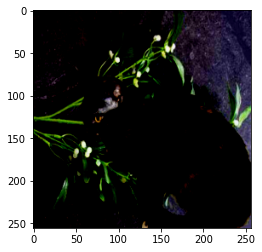

In [20]:
for value in train_dataloader:
    data, _ = value
    print(data.shape)
    plt.imshow(torch.squeeze(data).permute(1, 2, 0))
    break

In [21]:
def test(dataloader, model, y_pred_output):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    with torch.no_grad():
        for value in dataloader:
            X, _ = value
            X = X.to(device)
            y_pred = model(X).cpu().data.numpy().argmax()
            y_pred_output.append(y_pred)

In [22]:
y_pred_output = []
test(test_dataloader, model, y_pred_output)

In [23]:
sample = pd.read_csv("../input/dogs-vs-cats/sampleSubmission.csv")
i = sample.id

# dog = 1, cat = 0
def get_label(pred):
    return 1 if idx_to_class[pred] == "dog" else 0

output = pd.DataFrame({'id' : i, 'label':list(map(get_label, y_pred_output))})
output.head(20)

,id,label
0,1,1
1,2,0
2,3,0
3,4,1
4,5,1
5,6,0
6,7,0
7,8,1
8,9,1
9,10,0


In [24]:
output.to_csv('my_submission.csv', index=False)